In [2]:
import numpy as np

np.random.seed(100)

N = 100  # np.random.randint(100, 201)          # число спутников
data = np.zeros((N, 6), dtype=object)  # массив со всей информацией
data[:, :2] = np.random.random_sample((N, 2))  # x и y каждой точки
data[:, 2] = np.random.randint(-1, 2, N)  # источник/сток/ничего
data[:, 3] = np.random.randint(4, 11, N)  # число связей (соседей) каждой точки
if sum(data[:, 3]) % 2 != 0:
    data[np.argmax(data[:, 3]), 3] -= 1

array = np.array([[-1, 0], [0, 0], [1, 0]])


# функция, рандомно генерирующая соседей для каждой точки
def get_neighbours():
    bonds = np.zeros(N, dtype=object)
    bonds += data[:, 3]
    sorted_bonds = sorted([[i, bonds[i]] for i in range(N)], key=lambda i: i[1], reverse=True)

    keys = []
    neighbours_total = []
    for i in range(N):
        keys.append(sorted_bonds[i][0])
        neighbours_total.append([])

    while len(keys) > 0:
        n = keys[0]
        del keys[0]
        x_n = data[n, 0]
        y_n = data[n, 1]
        distances = np.zeros(N, dtype=object)

        for i in range(N):
            distance_variants = np.zeros(3)
            for j in range(3):
                distance_variants[j] = ((x_n - (data[i, 0] + array[j][0])) ** 2 +
                                        (y_n - (data[i, 1] + array[j][1])) ** 2) ** (1 / 2)
            distances[i] = [np.argmin(distance_variants), distance_variants[np.argmin(distance_variants)]]

        radius = 0
        points_in_radius = []
        while len(points_in_radius) < bonds[n]:
            for i in range(N):
                if (distances[i][1] < radius) and not (i in points_in_radius) and not (i in [neib[0] for neib in neighbours_total[n]]) and (i in keys) and (i != n):
                    points_in_radius.append(i)
            radius += 0.01
            if radius > 2 ** (1 / 2):
                raise OverflowError

        neighbours = np.random.choice(points_in_radius, int(bonds[n]), False)

        neighbours_total[n] += [[neib, array[distances[neib][0]], distances[neib][1]] for neib in neighbours]

        for neib in neighbours:
            neighbours_total[neib].append([n, array[distances[neib][0]]*-1, distances[neib][1]])
            bonds[neib] -= 1
            if bonds[neib] == 0:
                del keys[keys.index(neib)]

    return neighbours_total


# не всегда функции get_neighbours() удается распределить соседей корректно для всех точек c 1 раза, поэтому:
for i in range(10):
    try:
        neighbours = get_neighbours()
        break
    except OverflowError:
        continue

for i in range(N):
    data[i, 4] = neighbours[i]

class Point:

    def __init__(self, number):
        self.number = number  # номер точки
        self.x = np.round(data[number, 0], 3)  # х
        self.y = np.round(data[number, 1], 3)  # у
        self.u = data[number, 2]  # значение функции u
        self.bounds = data[number, 3]  # число соседей
        self.neighbours = data[number, 4]  # соседи

        # заполнение матрицы системы А для каждой точки, не являющейся стоком/источником (чтобы найти коэффициенты
        # разложения лапласиана)
        if self.u == 0:
            dxdy = np.zeros((self.bounds, 2))

            for i in range(self.bounds):
                dxdy[i, 0] = (data[self.neighbours[i][0], 0] + self.neighbours[i][1][0]) - self.x
                dxdy[i, 1] = (data[self.neighbours[i][0], 1] + self.neighbours[i][1][1]) - self.y

            self.A = np.zeros((self.bounds + 1, self.bounds + 1))
            self.A[0, :] = np.ones(self.bounds + 1)
            self.A[1, 1:] = dxdy[:, 0]
            self.A[2, 1:] = dxdy[:, 1]
            self.A[3, 1:] = dxdy[:, 0] ** 2
            self.A[4, 1:] = dxdy[:, 1] ** 2

            if self.bounds == 4:
                self.b = np.array([0, 0, 0, 2, 2])

            if self.bounds == 5:
                self.A[5, 1:] = dxdy[:, 0] * dxdy[:, 1]
                self.b = np.array([0, 0, 0, 2, 2, 0])

            if self.bounds == 6:
                self.A[5, 1:] = dxdy[:, 0] * dxdy[:, 1]
                self.A[6, 1:] = dxdy[:, 0] ** 3
                self.b = np.array([0, 0, 0, 2, 2, 0, 0])

            if self.bounds == 7:
                self.A[5, 1:] = dxdy[:, 0] * dxdy[:, 1]
                self.A[6, 1:] = dxdy[:, 0] ** 3
                self.A[7, 1:] = dxdy[:, 0] ** 2 * dxdy[:, 1]
                self.b = np.array([0, 0, 0, 2, 2, 0, 0, 0])

            if self.bounds == 8:
                self.A[5, 1:] = dxdy[:, 0] * dxdy[:, 1]
                self.A[6, 1:] = dxdy[:, 0] ** 3
                self.A[7, 1:] = dxdy[:, 0] ** 2 * dxdy[:, 1]
                self.A[8, 1:] = dxdy[:, 0] * dxdy[:, 1] ** 2
                self.b = np.array([0, 0, 0, 2, 2, 0, 0, 0, 0])

            if self.bounds == 9:
                self.A[5, 1:] = dxdy[:, 0] * dxdy[:, 1]
                self.A[6, 1:] = dxdy[:, 0] ** 3
                self.A[7, 1:] = dxdy[:, 0] ** 2 * dxdy[:, 1]
                self.A[8, 1:] = dxdy[:, 0] * dxdy[:, 1] ** 2
                self.A[9, 1:] = dxdy[:, 1] ** 3
                self.b = np.array([0, 0, 0, 2, 2, 0, 0, 0, 0, 0])

            if self.bounds == 10:
                self.A[5, 1:] = dxdy[:, 0] * dxdy[:, 1]
                self.A[6, 1:] = dxdy[:, 0] ** 3
                self.A[7, 1:] = dxdy[:, 0] ** 2 * dxdy[:, 1]
                self.A[8, 1:] = dxdy[:, 0] * dxdy[:, 1] ** 2
                self.A[9, 1:] = dxdy[:, 1] ** 3
                self.A[10, 1:] = dxdy[:, 0] ** 4
                self.b = np.array([0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0])

            self.alpha = np.linalg.solve(self.A, self.b)  # коэффициенты разложения лапласиана

    # функция для вывода информации о точке через интерфейс
    def inp(self):
        data_neighbours = ''
        for i in range(self.bounds):
            neib = self.neighbours[i][0]
            data_neighbours += f'\n{(neib, np.round(data[neib, 0], 3), np.round(data[neib, 1], 3), np.round(self.neighbours[i][2], 3), data[neib, 2])} '
        return [self.number, (self.x, self.y), data_neighbours, self.u]

In [4]:
I = 100  # число итераций
points = [Point(k) for k in range(N)]  # массив точек
u0 = [point.u for point in points]

A = np.eye(N)
F = np.zeros(N)
for point in points:
    if point.u != 1 and point.u != -1:
        for j in range(point.bounds):
            A[point.number, point.number] = point.alpha[0]
            A[point.number, point.neighbours[j][0]] = point.alpha[j + 1]
    else:
        F[point.number] = point.u
        
U = np.triu(A, 1)
L = np.tril(A, -1)
D = np.diag(np.diag(A))
D_inv = np.linalg.inv(D)    
LD_inv = np.linalg.inv(L + D)



u = np.zeros(I+1, dtype=object)
u[0]=u0
for i in range(I):
    u[i+1] = - np.dot(np.dot(D_inv, L + U), u[i]) + np.dot(D_inv, F)
    

for i in range(N):
    print(i, u[I-1][i])

0 -1.0
1 1.0
2 -1.0
3 -1.0
4 -1.0
5 -0.8976792497507029
6 6.0348069777341475
7 -4.241094675330393e+32
8 -1.0
9 1.0
10 1.0
11 -1.0
12 -1.0
13 0.9263717565014638
14 -1.0
15 2.413216308678843e+34
16 -6.910190407761557e+28
17 -6.0027423138652035e+31
18 -1.0
19 1.0
20 -1.04094326960808e+35
21 1.0
22 -1.0
23 -1.0
24 1.0
25 1.0
26 -6.309682012915162e+30
27 -1.688568868678446
28 -1.0
29 1.0
30 -1.0
31 -1.0
32 -1.0179777457268196e+32
33 1.0
34 1.0
35 1.0
36 1.0
37 1.0
38 -4.593246564561177e+30
39 -1.0
40 2.4125795741245044
41 -1.0
42 -0.63589054157529
43 -1.0
44 1.0
45 1.0
46 -1.0
47 -1.0
48 5.980716029365401e+30
49 -1.0
50 5.777963260942285e+33
51 1.0
52 1.0867259569520898e+33
53 1.0
54 -1.0
55 -1.0
56 2.0406054999317302e+32
57 -1.1732506386587256e+29
58 1.0
59 -1.0
60 5.8443180432131524e+32
61 4.078157520990209
62 -1.0
63 -0.5187691982848618
64 1.0
65 1.0
66 1.0
67 -1.0
68 3.7385472527400135e+33
69 2.129875871311094e+33
70 -1.0
71 0.7025810979560476
72 2.513968106160001
73 -1.0
74 -1.0
75 1.0

In [7]:
I = 100  # число итераций
points = [Point(k) for k in range(N)]  # массив точек
u0 = [point.u for point in points]

A = np.eye(N)
F = np.zeros(N)
for point in points:
    if point.u != 1 and point.u != -1:
        for j in range(point.bounds):
            A[point.number, point.number] = point.alpha[0]
            A[point.number, point.neighbours[j][0]] = point.alpha[j + 1]
    else:
        F[point.number] = point.u
        
U = np.triu(A, 1)
L = np.tril(A, -1)
D = np.diag(np.diag(A))
D_inv = np.linalg.inv(D)    
LD_inv = np.linalg.inv(L + D)



# Якоби
u = u0
for i in range(I):
    u_new = - np.dot(np.dot(D_inv, L + U), u) + np.dot(D_inv, F)
    u = u_new

yak = np.zeros(N)
for i in range(N):
    yak[i] = u_new[i]
    
aux = np.zeros(I, dtype=object)
aux[0]=u0
for i in range(1, I):
    aux[i] = - np.dot(np.dot(D_inv, L + U), aux[i-1]) + np.dot(D_inv, F)

    

# Зейдель
u = u0
for i in range(I):
    u_new = - np.dot(np.dot(LD_inv, U), u) + np.dot(LD_inv, F)
    u = u_new
    
zey = np.zeros(N)
for i in range(N):
    zey[i] = u_new[i]
    

# МПИ
u = u0
tau = 0.0001
for i in range(I):
    u_new = - np.dot(np.eye(N) - tau*A, u) + tau*F
    u = u_new
    
mpi = np.zeros(N)
for i in range(N):
    mpi[i] = u_new[i]
    


#no_name

for i in range(I):
    u = [point.u for point in points]
    for point in points:
        if point.u != 1 and point.u != -1:
            point.u = -np.dot(point.alpha[1:], [u[neib[0]] for neib in point.neighbours]) / point.alpha[0]

r = np.zeros(N)
for i in range(N):
    r[i] = points[i].u
    
    
import pandas as ps
output = np.zeros((N, 6))
for i in range(N):
    output[i] = np.round([r[i], yak[i], aux[I-1][i], zey[i], mpi[i], F[i]], 2)
out = ps.DataFrame(output, columns=['обычный', 'Якоби', 'Якоби1', 'Зейдель', 'МПИ', 'F'])
out.to_excel("output.xlsx")


0 1.0
1 1.0
2 1.0
3 1.0
4 1.0
8 1.0
9 1.0
10 1.0
11 1.0
12 1.0
14 1.0
18 1.0
19 1.0
21 1.0
22 1.0
23 1.0
24 1.0
25 1.0
28 1.0
29 1.0
30 1.0
31 1.0
33 1.0
34 1.0
35 1.0
36 1.0
37 1.0
39 1.0
41 1.0
43 1.0
44 1.0
45 1.0
46 1.0
47 1.0
49 1.0
51 1.0
53 1.0
54 1.0
55 1.0
58 1.0
59 1.0
62 1.0
64 1.0
65 1.0
66 1.0
67 1.0
70 1.0
73 1.0
74 1.0
75 1.0
77 1.0
79 1.0
83 1.0
85 1.0
86 1.0
88 1.0
90 1.0
91 1.0
92 1.0
93 1.0
94 1.0
95 1.0
96 1.0
98 1.0
99 1.0


In [11]:
l

65

In [28]:
eigv = list(set(np.round(np.linalg.eigh(A)[0])))
eigv

[1.0,
 770.0,
 -1785.0,
 9.0,
 -2294.0,
 11.0,
 139.0,
 3343.0,
 -751.0,
 -239.0,
 2707.0,
 17556.0,
 -2921.0,
 -360.0,
 26.0,
 -608.0,
 -2014.0,
 -1117.0,
 -478.0,
 164.0,
 3240.0,
 -471.0,
 683.0,
 -84.0,
 -11085.0,
 -714.0,
 54.0,
 1081.0,
 -708.0,
 -195.0,
 -12994.0,
 -1344.0,
 -2747.0,
 -1467.0,
 1862.0,
 456.0,
 -2103.0,
 3912.0,
 591.0,
 -944.0,
 30418.0,
 1235.0,
 -298.0,
 -30631.0,
 -3234.0,
 -18201.0,
 -150.0,
 491.0,
 -4371.0,
 110.0,
 243.0,
 5363.0,
 -138.0,
 2936.0,
 122.0,
 507.0,
 1276.0,
 -3.0]

In [30]:
from sympy import *
x = Symbol('x')

# ar = Matrix(x*D + L+U)
# ar

In [32]:


matrix_det(3)

-2.104323979899172e+149

In [62]:
f = np.zeros(len(x))
x = np.linspace(-1, 1, 100)
for i in range(len(x)):
    f[i] = matrix_det(x[i])
    print(i,x[i], f[i])


0 -1.0 -3.8336226552011143e+102
1 -0.9797979797979798 -4.831279123975104e+101
2 -0.9595959595959596 -5.5894591268226745e+100
3 -0.9393939393939394 -5.800835869067864e+99
4 -0.9191919191919192 -5.1433239981799546e+98
5 -0.898989898989899 -3.366411429795686e+97
6 -0.8787878787878788 -3.6481523738726605e+95
7 -0.8585858585858586 3.8196504927512677e+95
8 -0.8383838383838383 9.11125869633096e+94
9 -0.8181818181818181 1.5604721584101487e+94
10 -0.797979797979798 2.3736709782033655e+93
11 -0.7777777777777778 3.4233369451937294e+92
12 -0.7575757575757576 4.769581018998179e+91
13 -0.7373737373737373 6.3896856156816025e+90
14 -0.7171717171717171 8.114603628612529e+89
15 -0.696969696969697 9.622832611080135e+88
16 -0.6767676767676767 1.0523585641521054e+88
17 -0.6565656565656566 1.0509603528208255e+87
18 -0.6363636363636364 9.505550976966305e+85
19 -0.6161616161616161 7.723874461896537e+84
20 -0.5959595959595959 5.586790963138575e+83
21 -0.5757575757575757 3.55414085306372e+82
22 -0.5555555555555

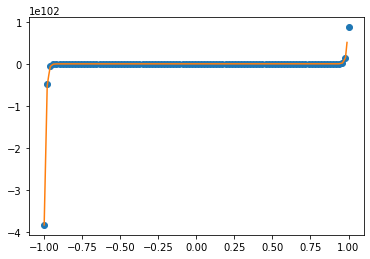

In [63]:
import matplotlib.pyplot as plt
from scipy import interpolate
f1 = interpolate.interp1d(x, f)
xnew = np.arange(-1, 1, 0.01)
ynew = f1(xnew)
plt.plot(x, f, 'o', xnew, ynew, '-')
plt.show()

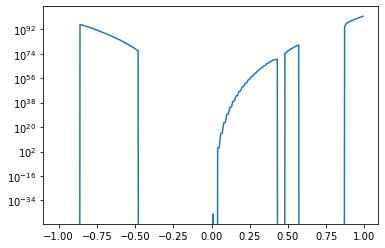

In [64]:
from pylab import *
figure = pylab.figure()

# Создадим поле для рисования и получим его оси
axes = figure.add_subplot (1, 1, 1)

# Установим логарифмический масштаб по оси Y
axes.set_yscale('log')
pylab.plot (xnew, ynew)


pylab.show()